In [8]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle
np.random.seed(247) # for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer
from theano.tensor.shared_randomstreams import RandomStreams
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

In [2]:
filename = 'Unlocalized_N=100000_S=200_M=50_G=20_data.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading data from: " + filepath
f = open(filepath, 'rb')
print "loading train data"
train = cPickle.load(f)
print "loading cross-validation data"
cross_validation = cPickle.load(f)
print "loading test data"
test = cPickle.load(f)
f.close()

X_train = train[0].transpose((0,1,2)).astype(np.float32)
y_train = train[1].astype(np.int32)
X_val = cross_validation[0].transpose((0,1,2)).astype(np.float32)
y_val = cross_validation[1].astype(np.int32)
X_test = test[0].transpose((0,1,2)).astype(np.float32)
y_test = test[1].astype(np.int32)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

train = (X_train, y_train, train[2])
valid = (X_val, y_val, cross_validation[2])
test = (X_test, y_test, test[2])

shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=50_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [3]:
model_name = "autoencode_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)

In [4]:
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)

Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.62472 -- accuracy=96.70%  
  valid loss:		0.36491
  valid accuracy:	0.97152+/-0.02402
  valid auc-roc:	0.94587+/-0.05670
  valid auc-pr:		0.66289+/-0.30702
saving model parameters to: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=50_G=20_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.27606 -- accuracy=97.88%  
  valid loss:		0.21739
  valid accuracy:	0.97916+/-0.01655
  valid auc-roc:	0.96593+/-0.03811
  valid auc-pr:		0.74632+/-0.26100
saving model parameters to: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=50_G=20_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.18125 -- accuracy=98.12%  
  valid loss:		0.16032
  valid accuracy:	0.98143+/-0.01607
  valid auc-roc:	0.97467+/-0.02728
  valid auc-pr:		0.78605+/-0.23856
saving model parameters to: /home/peter/Dat

In [5]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7ff2f4733ad0>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7ff28bbba5d0>,
 'conv1_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7ff28bbba590>,
 'conv1_bias': <lasagne.layers.special.BiasLayer at 0x7ff2f4733910>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7ff2f4733090>,
 'conv2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7ff28bbc4390>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7ff28bbc4550>,
 'conv2_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7ff28bbc4510>,
 'conv2_bias': <lasagne.layers.special.BiasLayer at 0x7ff28bbc43d0>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7ff28bbc4a90>,
 'conv3': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7ff28bbc4ad0>,
 'conv3_active': <lasagne.layers.special.NonlinearityLayer at 0x7ff28bbc4c90>,
 'conv3_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7ff28bbc4c50>,
 'conv3_bias': <lasagne.layers.special.BiasLa

In [6]:
class VariationalSampleLayer(layers.MergeLayer):
    def __init__(self, incoming_mu, incoming_logsigma, **kwargs):
        super(VariationalSampleLayer, self).__init__(incomings=[incoming_mu, incoming_logsigma], **kwargs)
        self.srng = RandomStreams(seed=234)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.srng.normal(shape, avg=0.0, std=1).astype(theano.config.floatX)


In [47]:
num_encode = 2

input_var = T.tensor4('inputs')
net = {}

# inference network
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['conv1'] = layers.Conv2DLayer(net['input'],  num_filters=network['conv1'].output_shape[1],
                                  filter_size=network['conv1'].filter_size,
                                  W=network['conv1'].W,
                                  b=init.Constant(0.05), 
                                  pad='same',
                                  nonlinearity=None, flip_filters=False)
net['conv1_norm'] = layers.BatchNormLayer(net['conv1'])
net['conv1_active'] = layers.NonlinearityLayer(net['conv1_norm'], nonlinearity=nonlinearities.rectify) 
net['conv1_pool'] = layers.MaxPool2DLayer(net['conv1_active'], pool_size=network['conv1_pool'].pool_size)

net['conv2'] = layers.Conv2DLayer(net['conv1_pool'],  num_filters=network['conv2'].output_shape[1],
                                  filter_size=network['conv2'].filter_size,
                                  W=network['conv2'].W,
                                  b=init.Constant(0.05), 
                                  pad='same',
                                  nonlinearity=None, flip_filters=False)
net['conv2_norm'] = layers.BatchNormLayer(net['conv2'])
net['conv2_active'] = layers.NonlinearityLayer(net['conv2_norm'], nonlinearity=nonlinearities.rectify) 
net['conv2_pool'] = layers.MaxPool2DLayer(net['conv2_active'], pool_size=network['conv2_pool'].pool_size)

net['conv3'] = layers.Conv2DLayer(net['conv2_pool'],  num_filters=network['conv3'].output_shape[1],
                                  filter_size=network['conv3'].filter_size,
                                  W=network['conv3'].W,
                                  b=init.Constant(0.05), 
                                  pad='same',
                                  nonlinearity=None, flip_filters=False)
net['conv3_norm'] = layers.BatchNormLayer(net['conv3'])
net['conv3_active'] = layers.NonlinearityLayer(net['conv3_norm'], nonlinearity=nonlinearities.rectify) 
net['conv3_pool'] = layers.MaxPool2DLayer(net['conv3_active'], pool_size=network['conv3_pool'].pool_size)

net['conv4'] = layers.Conv2DLayer(net['conv3_pool'],  num_filters=network['conv4'].output_shape[1],
                                  filter_size=network['conv1'].filter_size,
                                  W=network['conv4'].W,
                                  b=init.Constant(0.05), 
                                  pad='same',
                                  nonlinearity=None, flip_filters=False)
net['conv4_norm'] = layers.BatchNormLayer(net['conv4'])
net['conv4_active'] = layers.NonlinearityLayer(net['conv4_norm'], nonlinearity=nonlinearities.rectify) 
net['conv4_pool'] = layers.MaxPool2DLayer(net['conv4_active'], pool_size=network['conv4_pool'].pool_size)


# variational layer
net['encode_mu'] = layers.DenseLayer(net['conv4_pool'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['encode_logsigma'] = layers.DenseLayer(net['conv4_pool'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['Z'] = VariationalSampleLayer(net['encode_mu'], net['encode_logsigma'])


# generative network
num_units = np.prod(list(network['dense'].input_shape)[1:])
net['dense'] = layers.DenseLayer(net['Z'], num_units=num_units, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
shape2 = list(get_output_shape(net['conv4_pool']))
shape2[0] = -1
net['reshape'] = layers.ReshapeLayer(net['dense'], shape=tuple(shape2))

#net['invpool4'] = layers.Upscale2DLayer(net['reshape'], net['conv4_pool'].pool_size)
net['invpool4'] = layers.InverseLayer(net['reshape'], net['conv4_pool'])
net['invconv4']  = Conv2DLayer(net['invpool4'], num_filters=net['conv4'].input_shape[1],
                                          filter_size=net['conv4'].filter_size,
                                          W=init.GlorotUniform(),
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=None)
net['invconv4_norm'] = layers.BatchNormLayer(net['invconv4'])
net['invconv4_active'] = layers.NonlinearityLayer(net['invconv4_norm'], nonlinearity=nonlinearities.rectify) 

#net['invpool3'] = layers.Upscale2DLayer(net['invconv4_active'], net['conv3_pool'].pool_size)
net['invpool3'] = layers.InverseLayer(net['invconv4_active'], net['conv3_pool'])
net['invconv3']  = Conv2DLayer(net['invpool3'], num_filters=net['conv3'].input_shape[1],
                                          filter_size=net['conv3'].filter_size,
                                          W=init.GlorotUniform(),
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=None)
net['invconv3_norm'] = layers.BatchNormLayer(net['invconv3'])
net['invconv3_active'] = layers.NonlinearityLayer(net['invconv3_norm'], nonlinearity=nonlinearities.rectify) 


#net['invpool2'] = layers.Upscale2DLayer(net['invconv3_active'], net['conv2_pool'].pool_size)
net['invpool2'] = layers.InverseLayer(net['invconv3_active'], net['conv2_pool'])
net['invconv2']  = Conv2DLayer(net['invpool2'], num_filters=net['conv2'].input_shape[1],
                                          filter_size=net['conv2'].filter_size,
                                          W=init.GlorotUniform(),
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=None)
net['invconv2_norm'] = layers.BatchNormLayer(net['invconv2'])
net['invconv2_active'] = layers.NonlinearityLayer(net['invconv2_norm'], nonlinearity=nonlinearities.rectify) 


#net['invpool1'] = layers.Upscale2DLayer(net['invconv2_active'], net['conv1_pool'].pool_size)
net['invpool1'] = layers.InverseLayer(net['invconv2_active'], net['conv1_pool'])
net['invconv1']  = Conv2DLayer(net['invpool1'], num_filters=net['conv1'].input_shape[1],
                                          filter_size=net['conv1'].filter_size,
                                          W=init.GlorotUniform(),
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=None)
net['invconv1_norm'] = layers.BatchNormLayer(net['invconv1'])
net['invconv1_active'] = layers.NonlinearityLayer(net['invconv1_norm'], nonlinearity=nonlinearities.sigmoid) 

net['X'] = net['invconv1_active']


In [48]:
def build_loss(net, target_var, deterministic):
    
    z_mu = get_output(net['encode_mu'], deterministic=deterministic)
    z_logsigma = get_output(net['encode_logsigma'], deterministic=deterministic)
    kl_divergence = 0.5*T.sum(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma), axis=1)
    x_mu = get_output(net['X'], deterministic=deterministic)
    x_mu = T.clip(x_mu, 1e-7, 1-1e-7)
    x_logsigma = .5#T.log(T.sqrt(x_mu*(1-x_mu)))

    target_var = target_var.reshape((target_var.shape[0],-1))
    x_mu = x_mu.reshape((x_mu.shape[0],-1))

    log_likelihood = T.sum(-0.5*T.log(2*np.float32(np.pi))- x_logsigma - 0.5*T.sqr(target_var-x_mu)/T.exp(2*x_logsigma), axis=1)
    variational_lower_bound = -log_likelihood - kl_divergence
    prediction = x_mu
    return variational_lower_bound.mean(), prediction, kl_divergence, log_likelihood 

train_loss, train_prediction, train_kl, train_like = build_loss(net, input_var, deterministic=False)
test_loss, test_prediction, test_kl, test_like = build_loss(net, input_var, deterministic=True)


# ADAM updates
params = get_all_params(net['X'], trainable=True)
update_op = updates.adam(train_loss, params, learning_rate=.0001)
train_fun = theano.function([input_var], [train_loss] , updates=update_op)
valid_fun = theano.function([input_var], [test_loss, test_prediction, test_kl, test_like])

In [49]:
def batch_generator(X, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)
        
        
num_epochs = 100
batch_size = 100
num_train_batches = X_train.shape[0] // batch_size
num_valid_batches = X_val.shape[0] // batch_size
    
for epoch in range(num_epochs):
    train_batches = batch_generator(X_train, batch_size, shuffle=True)
    valid_batches = batch_generator(X_val, batch_size, shuffle=False)

    train_loss = 0
    for index in range(num_train_batches):
        loss = train_fun(next(train_batches))
        train_loss += loss[0]
        
    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))

Epoch 1 of 100
  training loss:		1162.153094
Epoch 2 of 100
  training loss:		1151.408169
Epoch 3 of 100
  training loss:		1148.446377
Epoch 4 of 100
  training loss:		1146.789202
Epoch 5 of 100
  training loss:		1145.396560
Epoch 6 of 100
  training loss:		1144.218647
Epoch 7 of 100
  training loss:		1143.189240
Epoch 8 of 100
  training loss:		1142.347435
Epoch 9 of 100
  training loss:		1141.609883
Epoch 10 of 100
  training loss:		1140.957489
Epoch 11 of 100
  training loss:		1140.317675
Epoch 12 of 100
  training loss:		1139.842502


KeyboardInterrupt: 

In [40]:
import pandas as pd
def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


In [50]:
# save some example pictures so we can see what it's done 
pred_fn = theano.function([input_var], get_output(net['X'], deterministic=True))


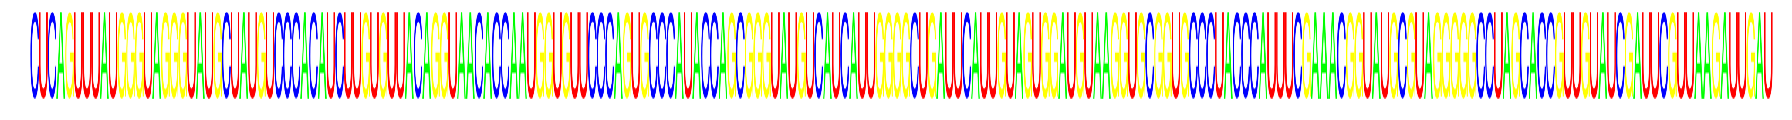

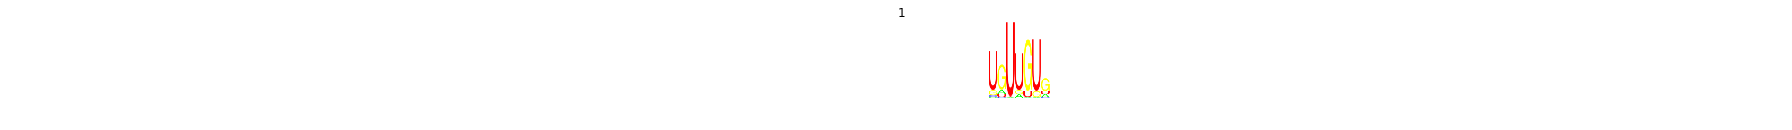

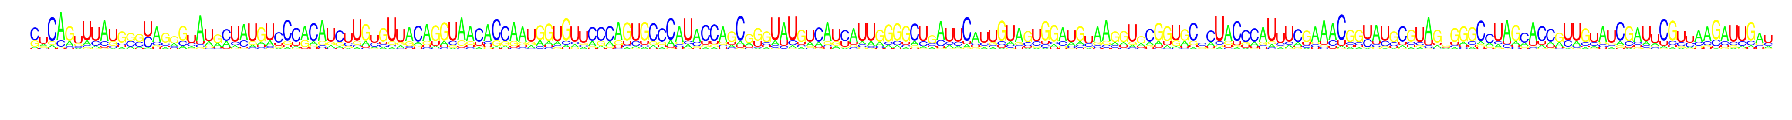

In [93]:

index=8
prediction = pred_fn(np.expand_dims(test[0][index],0).astype(np.float32))
prediction = prediction.reshape([4,200])
class_index = np.argmax(test[1][index])
model = test[2][index]

height=100
bp_width=20
num_seq = prediction.shape[1]
width = bp_width*num_seq
size = (25.,10.0)

logo = seq_logo(np.squeeze(test[0][index]), height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');

logo = seq_logo(model, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
plt.title(str(class_index))

pwm = prediction
MAX = np.max(pwm)
pwm = pwm/np.outer(np.ones(4), np.sum(pwm,axis=0))

logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');


<Container object of 3 artists>

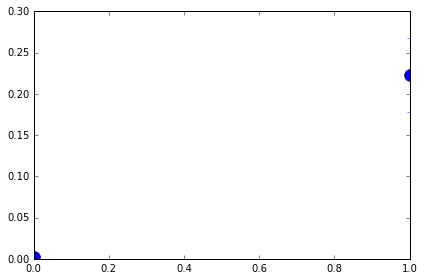

In [52]:
def statistics(net, target_var):
    z_mu = get_output(net['encode_mu'], deterministic=True)
    z_logsigma = get_output(net['encode_logsigma'], deterministic=True)
    x_mu = get_output(net['X'], deterministic=True)
    x_mu = T.clip(x_mu, 1e-7, 1-1e-7)
    x_logsigma = .5#T.log(T.sqrt(x_mu*(1-x_mu)))
    kl_divergence = 0.5*(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma))
    log_likelihood = -0.5*T.log(2*np.float32(np.pi))- x_logsigma - 0.5*T.sqr(target_var-x_mu)/T.exp(2*x_logsigma)
    return kl_divergence, log_likelihood
kl_divergence, log_likelihood = statistics(net, input_var)

statistics_fun = theano.function([input_var],[kl_divergence, log_likelihood])

batch_size = 100
num_test_batches = X_val.shape[0] // batch_size
test_batches = batch_generator(X_val, batch_size, shuffle=False)

kldiv = []
logL = []
for index in range(num_test_batches):
    stats = statistics_fun(next(test_batches))
    kldiv.append(stats[0])
    logL.append(stats[1])

kldiv = np.array(kldiv).reshape([-1,stats[0].shape[1]])
logL = np.array(logL).reshape([-1,stats[1].shape[1]])


plt.figure
plt.errorbar(range(num_encode),-np.mean(kldiv,axis=0),np.std(kldiv,axis=0), fmt='o', markersize=12)


In [88]:
z = get_output(net['Z'], deterministic=True)
test_fun = theano.function([input_var], z)

batch_size = 100
num_test_batches = test[0].shape[0] // batch_size
test_batches = batch_generator(test[0], batch_size, shuffle=False)
    
prediction = []
for index in range(num_test_batches):
    prediction.append(test_fun(next(test_batches)))
    
prediction = np.array(prediction)
prediction = prediction.reshape([-1,num_encode])

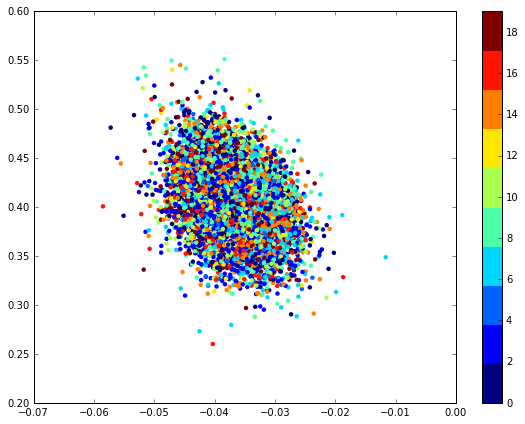

In [55]:
y = np.argmax(test[1],axis=1)

plt.figure(figsize=(8, 6)) 
plt.scatter(prediction[:,0], prediction[:,1], c=y[:prediction.shape[0]], cmap=plt.cm.get_cmap("jet", 10),  edgecolor='none')
plt.colorbar()

In [91]:
z_var = T.vector()
generated_x = get_output(net['X'], {net['encode_mu']:z_var}, deterministic=True)
gen_fn = theano.function([z_var], generated_x, allow_input_downcast=True)

MissingInputError: ("An input of the graph, used to compute AbstractConv2d{border_mode='half', subsample=(1, 1), filter_flip=False, imshp=(None, 4, 200, 1), kshp=(64, 4, 11, 1)}(inputs, HostFromGpu.0), was not provided and not given a value.Use the Theano flag exception_verbosity='high',for more information on this error.", inputs)

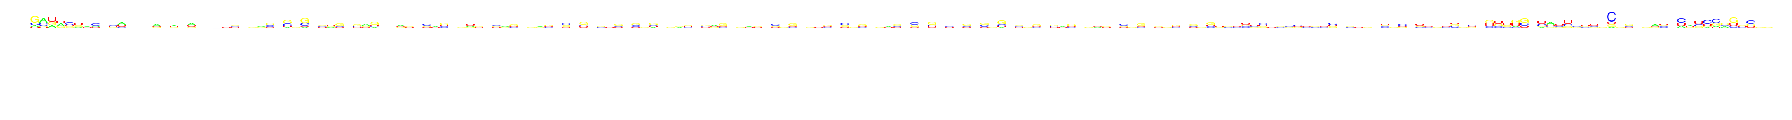

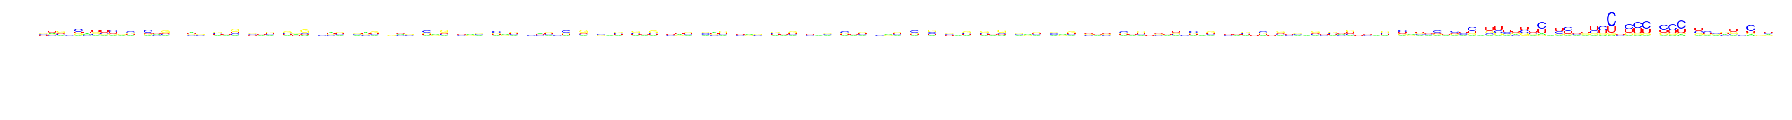

In [85]:
prediction = gen_fn(np.ones((1,4,200,1)), np.array([0.,.5]))

pwm = np.squeeze(prediction[0])
pwm = pwm/np.outer(np.ones(4), np.sum(pwm,axis=0))

logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');


prediction = gen_fn(np.zeros((1,4,200,1)), np.array([0., 0.]))

pwm = np.squeeze(prediction[0])
pwm = pwm/np.outer(np.ones(4), np.sum(pwm,axis=0))

logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');



In [90]:
np.max(prediction,axis=0)

array([-0.01164706,  0.55121744], dtype=float32)

# MNIST 

In [ ]:
# load mnist data
fname = '/home/peter/Data/mnist/mnist.pkl.gz'
f = gzip.open(fname, 'rb')
train_set, valid_set, test_set = pickle.load(f)
f.close()
X_train, y_train = train_set
X_valid, y_valid = valid_set
X_test, y_test = test_set

num_labels = 10
num_train = len(y_train)
num_valid = len(y_valid)
num_test = len(y_test)
X_train = X_train.reshape([-1,1,28,28])

In [ ]:
class VariationalSampleLayer(layers.MergeLayer):
    def __init__(self, incoming_mu, incoming_logsigma, **kwargs):
        super(VariationalSampleLayer, self).__init__(incomings=[incoming_mu, incoming_logsigma], **kwargs)
        self.srng = RandomStreams(seed=234)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.srng.normal(shape, avg=0.0, std=1).astype(theano.config.floatX)


In [ ]:
num_encode=2
num_units=500
x_dim = 28*28

input_var = T.tensor4('inputs')
net = {}
net['input'] = layers.InputLayer(shape=(None,1,28,28), input_var=input_var)
net['conv1'] = layers.Conv2DLayer(net['input'],  num_filters=25,
                                  filter_size=(5,5),
                                  W=init.GlorotUniform(),
                                  b=None, 
                                  pad='same')

net['conv1_bias'] = layers.BiasLayer(net['conv1'], b=init.Constant(0.05))
net['conv1_norm'] = layers.BatchNormLayer(net['conv1_bias'])
net['conv1_active'] = layers.NonlinearityLayer(net['conv1_norm'],nonlinearity=nonlinearities.rectify) 
net['conv1_pool'] = layers.MaxPool2DLayer(net['conv1_active'], pool_size=(2,2))

net['conv2'] = layers.Conv2DLayer(net['conv1_pool'],  num_filters=50,
                                  filter_size=(3,3),
                                  W=init.GlorotUniform(),
                                  b=None, 
                                  pad='same')
net['conv2_bias'] = layers.BiasLayer(net['conv2'], b=init.Constant(0.05))
net['conv2_norm'] = layers.BatchNormLayer(net['conv2_bias'])
net['conv2_active'] = layers.NonlinearityLayer(net['conv2_norm'],nonlinearity=nonlinearities.rectify)                          
net['conv2_pool'] = layers.MaxPool2DLayer(net['conv2_active'], pool_size=(2,2))
                                            
         
net['dense1'] = layers.DenseLayer(net['conv2_pool'], num_units=100, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
net['dense2'] = layers.DenseLayer(net['dense1'], num_units=100, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
                                  
net['encode_mu'] = layers.DenseLayer(net['dense2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['encode_logsigma'] = layers.DenseLayer(net['dense2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['Z'] = VariationalSampleLayer(net['encode_mu'], net['encode_logsigma'])
                                  
net['invline'] = layers.DenseLayer(net['Z'], num_units=net['dense2'].input_shape[1], W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['invdense2'] = layers.DenseLayer(net['invline'], num_units=net['dense2'].input_shape[1], W=net['dense2'].W.dimshuffle([1,0]), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
num_units = np.prod(list(net['dense1'].input_shape)[1:])
net['invdense1'] = layers.DenseLayer(net['invdense2'], num_units=num_units, W=net['dense1'].W.dimshuffle([1,0]), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
shape = list(get_output_shape(net['conv2_pool']))
shape[0] = -1
net['reshape'] = layers.ReshapeLayer(net['invdense1'], shape=tuple(shape))

net['invpool2'] = layers.Upscale2DLayer(net['reshape'], (2,2))
net['invconv2']  = Conv2DLayer(net['invpool2'], num_filters=net['conv2'].input_shape[1],
                                          filter_size=net['conv2'].filter_size,
                                          W=net['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)


net['invpool1'] = layers.Upscale2DLayer(net['invconv2'], (2,2))
net['X']  = Conv2DLayer(net['invpool1'], num_filters=net['conv1'].input_shape[1],
                                          filter_size=net['conv1'].filter_size,
                                          W=net['conv1'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.sigmoid, flip_filters=True)

In [ ]:
def build_loss(net, target_var, deterministic):
    
    z_mu = get_output(net['encode_mu'], deterministic=deterministic)
    z_logsigma = get_output(net['encode_logsigma'], deterministic=deterministic)
    kl_divergence = 0.5*T.sum(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma), axis=1)
    
    x_mu = get_output(net['X'], deterministic=deterministic)
    x_mu = T.clip(x_mu, 1e-7, 1-1e-7)
    
    num_data = target_var.shape[0]
    target_var = target_var.reshape([num_data,-1])
    x_mu = x_mu.reshape([num_data, -1])
    log_likelihood = T.sum(target_var*T.log(1e-10+x_mu) + (1.0-target_var)*T.log(1e-10+1.0-x_mu), axis=1)
    variational_lower_bound = -log_likelihood - kl_divergence
    prediction = x_mu
    return variational_lower_bound.mean(), prediction

train_loss, train_prediction = build_loss(net, input_var, deterministic=False)

# ADAM updates
params = get_all_params(net['X'], trainable=True)
update_op = updates.adam(train_loss, params, learning_rate=1e-3)
train_fun = theano.function([input_var], train_loss, updates=update_op)

In [ ]:
def batch_generator(X, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)
        
num_epochs = 60
batch_size = 100
num_train_batches = X_train.shape[0] // batch_size
    
for epoch in range(num_epochs):
    train_batches = batch_generator(X_train, batch_size, shuffle=True)

    train_loss = 0
    for index in range(num_train_batches):
        loss = train_fun(next(train_batches))
        train_loss += loss
        
    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))

In [ ]:
# save some example pictures so we can see what it's done 
example_batch_size = 100
X_comp = X_test[:example_batch_size]
X_comp = X_comp.reshape([-1,1,28,28])
pred_fn = theano.function([input_var], get_output(net['X'], deterministic=True))
X_pred = pred_fn(X_comp)

width = 10
height = 10

plt.figure(figsize = (height,width))
fig = plt.gcf()
fig.set_size_inches(100, 100, forward=True)
gs = mpl.gridspec.GridSpec(height, width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(width*height):
    img = np.reshape(X_comp[i], [28,28])
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(img), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()



plt.figure(figsize = (height,width))
fig = plt.gcf()
fig.set_size_inches(100, 100, forward=True)
gs = mpl.gridspec.GridSpec(height, width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(width*height):
    img = np.reshape(X_pred[i], [28,28])
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(img), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()


In [ ]:
z = get_output(net['Z'], deterministic=True)
test_fun = theano.function([input_var], z)

batch_size = 100
num_test_batches = X_test.shape[0] // batch_size
test_batches = batch_generator(X_test.reshape([-1,1,28,28]), batch_size, shuffle=False)
    
prediction = []
for index in range(num_test_batches):
    prediction.append(test_fun(next(test_batches)))
    
prediction = np.array(prediction).reshape([-1,2])

plt.figure(figsize=(8, 6)) 
plt.scatter(prediction[:,0], prediction[:,1], c=y_test, cmap=plt.cm.get_cmap("jet", 10),  edgecolor='none')
plt.colorbar()

In [ ]:
z_var = T.vector()
generated_x = get_output(net['X'], {net['encode_mu']:z_var}, 
            deterministic=True)
gen_fn = theano.function([z_var], generated_x)

num_grid = 20
width = 28
height = 28
tile_img = np.zeros((width*num_grid,height*num_grid))
MIN = np.min(prediction)
MAX = np.max(prediction)
pos = np.linspace(MIN,MAX,num_grid)
for i in range(num_grid):
    for j in range(num_grid):
        z = np.asarray([pos[i], pos[j]], dtype=theano.config.floatX)
        x_gen = gen_fn(z).reshape(-1, 1, width, height)
        tile_img[i*height:(i+1)*height, j*width:(j+1)*width] = x_gen
        
plt.figure(figsize=(10, 10))
plt.imshow(tile_img, cmap='gray')
plt.axis('off')